In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import json
import pickle
from pathlib import Path
import time
from collections import defaultdict
import matplotlib.pyplot as plte
from PIL import Image
import requests
from io import BytesIO
import os
import tensorflow_datasets as tfds
import matplotlib.image as mpimg
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from sklearn.model_selection import train_test_split
import glob
import matplotlib.image as mpimg


In [26]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Mixed precision policy set to:', policy.name)

Mixed precision policy set to: mixed_float16


In [49]:
pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [27]:
# Configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EMBEDDING_DIM = 256
# UNITS = 512
UNITS = 768
VOCAB_SIZE = None
MAX_LENGTH = 50
EPOCHS = 20
ATTENTION_FEATURES_SHAPE = 64

In [28]:
import json
import os
from collections import defaultdict
from pathlib import Path
import numpy as np
from PIL import Image

# --- Configuration des chemins Kaggle ---
# Basé sur votre image, le chemin racine semble être celui-ci :
BASE_PATH = '/kaggle/input/coco-2017-dataset/coco2017'

# Chemin vers le fichier d'annotations d'entraînement
TRAIN_ANNOTATIONS_FILE = os.path.join(BASE_PATH, 'annotations', 'captions_train2017.json')

# Chemin vers le dossier des images d'entraînement
TRAIN_IMAGES_DIR = os.path.join(BASE_PATH, 'train2017')

print(f"Fichier d'annotations : {TRAIN_ANNOTATIONS_FILE}")
print(f"Dossier des images     : {TRAIN_IMAGES_DIR}")

# Définir une limite pour le nombre d'échantillons
# Le dataset COCO train complet (~118k images) est trop volumineux
# pour être chargé en RAM (ce que fait le notebook original).
# L'original utilisait 10% de TFDS. 30000 est un bon point de départ.
NUM_SAMPLES_TO_USE = 40000

Fichier d'annotations : /kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json
Dossier des images     : /kaggle/input/coco-2017-dataset/coco2017/train2017


In [29]:
# Dossiers de cache (identique à l'original)
feature_cache_dir = './cached_features'
if not os.path.exists(feature_cache_dir):
    os.makedirs(feature_cache_dir)

print("🔹 Chargement et parsing des annotations JSON...")
with open(TRAIN_ANNOTATIONS_FILE, 'r') as f:
    annotations_data = json.load(f)

# --- 1. Créer des mappings depuis le JSON ---

# Map img_id -> nom_de_fichier
img_id_to_filename = {img['id']: img['file_name'] for img in annotations_data['images']}

# Map img_id -> liste de légendes
img_id_to_captions = defaultdict(list)
for ann in annotations_data['annotations']:
    img_id_to_captions[ann['image_id']].append(ann['caption'])

print(f"Trouvé {len(img_id_to_filename)} images et {len(annotations_data['annotations'])} légendes dans le JSON.")

# --- 2. Échantillonner les données ---
all_image_ids = list(img_id_to_filename.keys())
# S'assurer qu'on ne demande pas plus d'échantillons qu'il n'y en a
NUM_SAMPLES_TO_USE = min(NUM_SAMPLES_TO_USE, len(all_image_ids))

print(f"🔹 Échantillonnage de {NUM_SAMPLES_TO_USE} images aléatoires...")
# Fixer le seed pour la reproductibilité
np.random.seed(42)
sampled_image_ids = np.random.choice(all_image_ids, NUM_SAMPLES_TO_USE, replace=False)

# --- 3. Construire les listes pour le feature extractor ---
# image_path_to_caption map: chemin_feature_NPY -> [légendes]
# source_image_paths list: [chemin_image_JPG_source]
# feature_paths_list list: [chemin_feature_NPY_destination]

image_path_to_caption = defaultdict(list)
source_image_paths = []
feature_paths_list = []

print("🔹 Construction des mappings image -> légende...")
for idx, img_id in enumerate(sampled_image_ids):
    file_name = img_id_to_filename[img_id]
    full_image_path = os.path.join(TRAIN_IMAGES_DIR, file_name)

    # Vérifier si l'image existe réellement sur le disque
    if not os.path.exists(full_image_path):
        # print(f"Warning: Fichier image non trouvé, skip: {full_image_path}")
        continue

    # Récupérer et nettoyer les légendes
    captions_raw = img_id_to_captions[img_id]
    caps_clean = []
    for c in captions_raw:
        cap = '<start> ' + str(c).strip() + ' <end>'
        caps_clean.append(cap)

    # Définir le chemin de destination pour le feature .npy
    # (identique à la logique originale)
    feature_name = str(Path(feature_cache_dir) / f"{idx:012d}.npy")

    image_path_to_caption[feature_name] = caps_clean
    source_image_paths.append(full_image_path)
    feature_paths_list.append(feature_name)

print(f"✅ {len(source_image_paths)} paires image/légende prêtes pour l'extraction.")
print(f"Exemple de chemin source: {source_image_paths[0]}")
print(f"Exemple de chemin feature: {feature_paths_list[0]}")
print(f"Exemple de légende: {image_path_to_caption[feature_paths_list[0]][0]}")

🔹 Chargement et parsing des annotations JSON...
Trouvé 118287 images et 591753 légendes dans le JSON.
🔹 Échantillonnage de 40000 images aléatoires...
🔹 Construction des mappings image -> légende...
✅ 40000 paires image/légende prêtes pour l'extraction.
Exemple de chemin source: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000303308.jpg
Exemple de chemin feature: cached_features/000000000000.npy
Exemple de légende: <start> A refrigerator freezer next to a stove top oven. <end>


In [30]:
# --- Feature Extractor InceptionV3 ---
print("🔹 Chargement du modèle InceptionV3 (ImageNet, sans top)...")
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
print("✅ InceptionV3 feature extractor prêt.")


🔹 Chargement du modèle InceptionV3 (ImageNet, sans top)...
✅ InceptionV3 feature extractor prêt.


In [31]:
# Fonction de prétraitement pour InceptionV3
def preprocess_for_inception(image_path):
    """
    Lit une image depuis un chemin, la redimensionne et la normalise
    pour InceptionV3.
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_and_save_features(image_paths, feature_cache_dir, batch_size=16):
    """
    Extrait les features InceptionV3 pour une liste d'images et les sauvegarde
    dans des fichiers .npy (1 par image).
    """
    print(f"🔹 Extraction des features pour {len(image_paths)} images...")

    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_for_inception, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)

    total_saved = 0
    for batch_idx, batch_imgs in enumerate(dataset):
        batch_features = image_features_extract_model(batch_imgs)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

        for i, features in enumerate(batch_features):
            img_idx = total_saved + i
            feature_path = Path(feature_cache_dir) / f"{img_idx:012d}.npy"
            np.save(feature_path, features.numpy())

        total_saved += batch_features.shape[0]
        print(f"  ✔️ Batch {batch_idx+1}: {batch_features.shape[0]} images traitées.")

    print(f"✅ Extraction terminée : {total_saved} fichiers .npy enregistrés.")

In [32]:
print(f"🔹 Extraction des features pour {len(source_image_paths)} images...")

# Utiliser la liste des chemins de fichiers sources (JPG)
image_dataset = tf.data.Dataset.from_tensor_slices(source_image_paths)

# Utiliser la fonction de preprocessing qui lit les fichiers
# (définie dans la cellule 6)
image_dataset = image_dataset.map(preprocess_for_inception,
                                  num_parallel_calls=tf.data.AUTOTUNE)

# Batcher le dataset
image_dataset = image_dataset.batch(BATCH_SIZE)

total_saved = 0
for batch_idx, batch_imgs in enumerate(image_dataset):
    # Extraire les features
    batch_features = image_features_extract_model(batch_imgs)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    # Sauvegarder chaque feature dans son fichier .npy
    for i, features in enumerate(batch_features):
        # Récupérer le chemin .npy de destination correct
        feature_path = feature_paths_list[total_saved + i]
        np.save(feature_path, features.numpy())

    total_saved += batch_features.shape[0]
    if batch_idx % 50 == 0:
        print(f"  ✔️ Batch {batch_idx+1}: Traitement {total_saved}/{len(source_image_paths)} images.")

print(f"✅ Extraction terminée: {total_saved} fichiers .npy sauvegardés dans {feature_cache_dir}.")

🔹 Extraction des features pour 40000 images...
  ✔️ Batch 1: Traitement 64/40000 images.
  ✔️ Batch 51: Traitement 3264/40000 images.
  ✔️ Batch 101: Traitement 6464/40000 images.
  ✔️ Batch 151: Traitement 9664/40000 images.
  ✔️ Batch 201: Traitement 12864/40000 images.
  ✔️ Batch 251: Traitement 16064/40000 images.
  ✔️ Batch 301: Traitement 19264/40000 images.
  ✔️ Batch 351: Traitement 22464/40000 images.
  ✔️ Batch 401: Traitement 25664/40000 images.
  ✔️ Batch 451: Traitement 28864/40000 images.
  ✔️ Batch 501: Traitement 32064/40000 images.
  ✔️ Batch 551: Traitement 35264/40000 images.
  ✔️ Batch 601: Traitement 38464/40000 images.
✅ Extraction terminée: 40000 fichiers .npy sauvegardés dans ./cached_features.


In [33]:
# Construire img_name_vector et train_captions à partir du mapping
image_paths = list(image_path_to_caption.keys())
train_captions = []
img_name_vector = []
for img_path in image_paths:
    caption_list = image_path_to_caption[img_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([img_path] * len(caption_list))

print(f"Total training samples (image-caption pairs): {len(train_captions)}")
print(f"Unique images (features): {len(image_paths)}")

# Construire split train/val sur les paires (on fera un split sur les paires)
VAL_SPLIT = 0.2
RANDOM_STATE = 42

img_train, img_val, cap_train, cap_val = train_test_split(
    img_name_vector,
    train_captions,  # <-- CORRECTION : Passez la liste de strings directement
    test_size=VAL_SPLIT,
    random_state=RANDOM_STATE
)

Total training samples (image-caption pairs): 200102
Unique images (features): 40000


In [34]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=VOCAB_SIZE, # VOCAB_SIZE is None, so it uses all words
    oov_token="<unk>",
    filters='!\\\"#$%&()*+.,-/:;=?@[\\\\]^_`{|}~ '
)
tokenizer.fit_on_texts(cap_train) # Fit ONLY on training captions
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

VOCAB_SIZE = len(tokenizer.word_index) + 1 # Update global config
print(f"Vocabulary size: {VOCAB_SIZE}")

train_seqs = tokenizer.texts_to_sequences(cap_train)
val_seqs = tokenizer.texts_to_sequences(cap_val)

cap_train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=MAX_LENGTH)
cap_val_pad = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post', maxlen=MAX_LENGTH)

print(f"Max caption length: {MAX_LENGTH}")

Vocabulary size: 15993
Max caption length: 50


In [35]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features (batch_size, 64, 256)

        # S'assurer que hidden est de rang 2 avant l'expansion
        if len(hidden.shape) == 1:
            hidden = tf.expand_dims(hidden, 0)

        hidden_with_time_axis = tf.expand_dims(hidden, 1) # (batch_size, 1, units)

        # score shape == (batch_size, 64, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after reduce_sum == (batch_size, EMBEDDING_DIM)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # --- NOUVEAU : Couche Dropout pour l'embedding (taux de 30-50%) ---
        self.dropout_embed = tf.keras.layers.Dropout(0.4)

        self.gru_cell = tf.keras.layers.GRUCell(
            self.units,
            recurrent_initializer='glorot_uniform'
        )

        self.fc1 = tf.keras.layers.Dense(self.units)

        # --- NOUVEAU : Couche Dropout pour la sortie (taux de 30-50%) ---
        self.dropout_fc = tf.keras.layers.Dropout(0.4)

        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    # --- MODIFIÉ : Ajout de l'argument 'training' ---
    def call(self, x, features, hidden, training=False):
        context_vector, attention_weights = self.attention(features, hidden)

        x = self.embedding(x)

        # --- NOUVEAU : Appliquer le dropout (seulement pendant l'entraînement) ---
        x = self.dropout_embed(x, training=training)

        x = tf.squeeze(x, axis=1)
        x_combined = tf.concat([context_vector, x], axis=-1)
        output_gru, [state] = self.gru_cell(x_combined, states=[hidden])

        x = self.fc1(output_gru)

        # --- NOUVEAU : Appliquer le dropout (seulement pendant l'entraînement) ---
        x = self.dropout_fc(x, training=training)

        x = tf.nn.relu(x)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
# class RNN_Decoder(tf.keras.Model):
#     def __init__(self, embedding_dim, units, vocab_size, dropout_rate=0.4):
#         super(RNN_Decoder, self).__init__()
#         self.units = units
#         self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#         self.dropout_embed = tf.keras.layers.Dropout(dropout_rate)

#         # LSTM au lieu de GRU
#         self.lstm_cell = tf.keras.layers.LSTMCell(
#             self.units,
#             recurrent_initializer='glorot_uniform',
#             dropout=0.2,  # dropout interne
#             recurrent_dropout=0.2  # dropout récurrent
#         )

#         self.fc1 = tf.keras.layers.Dense(self.units)
#         self.dropout_fc = tf.keras.layers.Dropout(dropout_rate)
#         self.fc2 = tf.keras.layers.Dense(vocab_size)
#         self.attention = BahdanauAttention(self.units)

#     def call(self, x, features, hidden, training=False):
#         # hidden est maintenant un tuple (h, c) pour LSTM
#         context_vector, attention_weights = self.attention(features, hidden[0])

#         x = self.embedding(x)
#         x = self.dropout_embed(x, training=training)
#         x = tf.squeeze(x, axis=1)

#         x_combined = tf.concat([context_vector, x], axis=-1)

#         # LSTM retourne (output, [h_state, c_state])
#         output_lstm, [h_state, c_state] = self.lstm_cell(x_combined, states=hidden)

#         x = self.fc1(output_lstm)
#         x = self.dropout_fc(x, training=training)
#         x = tf.nn.relu(x)
#         x = self.fc2(x)

#         return x, [h_state, c_state], attention_weights

#     def reset_state(self, batch_size):
#         # LSTM nécessite 2 états : hidden state et cell state
#         return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]


In [36]:
# confiuration pour lstm decoder
DECODER_TYPE = 'lstm'  # 'gru', 'lstm', 'stacked', 'transformer'
NUM_LAYERS = 2  # Pour stacked
NUM_HEADS = 8   # Pour transformer
DFF = 512       # Dimension feed-forward pour transformer
DROPOUT_RATE = 0.3  # Taux de dropout ajustable


In [37]:
# Initialize models
encoder = CNN_Encoder(EMBEDDING_DIM)
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, len(tokenizer.word_index))
# decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, len(tokenizer.word_index), DROPOUT_RATE)

print(" Models initialized")

 Models initialized


In [38]:
optimizer = tf.keras.optimizers.Adam()
optimizer = mixed_precision.LossScaleOptimizer(optimizer)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def map_func(img_name_tensor, cap_tensor):
    feature_path = img_name_tensor.decode('utf-8')
    feat = np.load(feature_path)
    return feat.astype(np.float32), cap_tensor

@tf.function
def tf_map_func(img_name, cap):
    # Wrap numpy_function in tf.function
    return tf.numpy_function(map_func, [img_name, cap], [tf.float32, tf.int32])

# Use the padded sequences (cap_train_pad, cap_val_pad)
train_datav1 = tf.data.Dataset.from_tensor_slices((img_train, cap_train_pad))
train_datav1 = train_datav1.map(tf_map_func, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_datav1.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_datav1 = tf.data.Dataset.from_tensor_slices((img_val, cap_val_pad))
val_datav1 = val_datav1.map(tf_map_func, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_datav1.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Training dataset prepared with {len(img_train)} samples.")
print(f"Validation dataset prepared with {len(img_val)} samples.")

Training dataset prepared with 160081 samples.
Validation dataset prepared with 40021 samples.


In [39]:
@tf.function
def train_step(img_tensor, target):
    loss = 0.0
    batch_size = tf.shape(target)[0]
    
    # Assuming reset_state returns a single tensor for GRU
    hidden = decoder.reset_state(batch_size=batch_size) # Starts as float32 
    
    start_token_id = tf.constant(tokenizer.word_index['<start>'], dtype=tf.int32)
    dec_input = tf.fill([batch_size, 1], start_token_id)
    sequence_length = tf.shape(target)[1]

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in tf.range(1, sequence_length):
            # Assuming decoder returns (predictions, next_state, attention_weights)
            predictions, hidden_next, _ = decoder(dec_input, features, hidden, training=True) # Pass training=True

            # --- CORRECTED FIX FOR GRU + Mixed Precision ---
            # Cast the single returned state tensor back to float32
            hidden = tf.cast(hidden_next, tf.float32)
            # --- END FIX ---

            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    # Calculate average loss per step JUST for potential separate logging (optional)
    # The gradient should be based on the SUM (loss) for stability in RNNs
    total_loss_avg_per_step = (loss / tf.cast(sequence_length - 1, tf.float32))

    # --- SIMPLIFIED GRADIENT CALCULATION ---
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    # Calculate gradients using the SUM of losses across the sequence
    gradients = tape.gradient(loss, trainable_variables) 
    
    # Apply gradients - LossScaleOptimizer handles scaling automatically here
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    # --- END SIMPLIFICATION ---

    # Return the SUM loss and the AVERAGE loss per step for logging
    return loss, total_loss_avg_per_step

In [40]:
@tf.function
def val_step(img_tensor, target):
    loss = 0.0
    batch_size = tf.shape(target)[0]

    # Initialize accuracy counters for the batch
    correct_tokens = tf.constant(0.0, dtype=tf.float32)
    total_relevant_tokens = tf.constant(0.0, dtype=tf.float32)

    hidden = decoder.reset_state(batch_size=batch_size)
    if isinstance(hidden, list): # Handle LSTM
         hidden = [tf.cast(s, tf.float32) for s in hidden]
    else: # Handle GRU
         hidden = tf.cast(hidden, tf.float32)

    start_token_id = tf.constant(tokenizer.word_index['<start>'], dtype=tf.int32)
    dec_input = tf.fill([batch_size, 1], start_token_id)
    sequence_length = tf.shape(target)[1]
    features = encoder(img_tensor)

    for i in tf.range(1, sequence_length):
        predictions, hidden_next, _ = decoder(dec_input, features, hidden, training=False)

        # Cast hidden state back for loop consistency (GRU/LSTM)
        if isinstance(hidden_next, list): 
             hidden = [tf.cast(s, tf.float32) for s in hidden_next]
        else: 
             hidden = tf.cast(hidden_next, tf.float32)

        # --- Calculate Loss (as before) ---
        current_loss = loss_function(target[:, i], predictions)
        loss += current_loss 

        # --- Calculate Accuracy ---
        target_tokens = target[:, i]
        predicted_tokens = tf.argmax(predictions, axis=1, output_type=tf.int32)

        # Create mask to ignore padding tokens (target == 0)
        mask = tf.math.not_equal(target_tokens, 0)

        # Compare predictions and targets where mask is True
        matches = tf.equal(predicted_tokens, target_tokens)
        correct_matches_masked = tf.logical_and(matches, mask)

        # Count correct tokens and total relevant tokens in this step
        correct_tokens += tf.reduce_sum(tf.cast(correct_matches_masked, tf.float32))
        total_relevant_tokens += tf.reduce_sum(tf.cast(mask, tf.float32))
        # --- End Accuracy Calculation ---

        # Teacher forcing
        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss_avg = (loss / tf.cast(sequence_length - 1, tf.float32))

    # Return average loss, total correct tokens, total relevant tokens for the batch
    return total_loss_avg, correct_tokens, total_relevant_tokens

In [51]:

# Télécharger les ressources NLTK nécessaires
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

# Pour CIDEr, utiliser pycocoevalcap
try:
    from pycocoevalcap.cider.cider import Cider
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.meteor.meteor import Meteor
    from pycocoevalcap.rouge.rouge import Rouge
    COCO_EVAL_AVAILABLE = True
except ImportError:
    print("pycocoevalcap non disponible. Installer avec: pip install pycocoevalcap")
    COCO_EVAL_AVAILABLE = False


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [42]:


def load_image(image_path):
    # Charger l'image avec Pillow
    img = Image.open(image_path).convert('RGB')  # Convertit en RGB même si PNG/WEBP

    # Redimensionner pour le modèle (InceptionV3 = 299x299)
    img = img.resize((299, 299))

    # Convertir en tableau numpy puis en tenseur
    img = np.array(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)

    # Prétraitement pour InceptionV3
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, image_path

In [43]:
def evaluate(image, beam_width=3):
    """
    Génère la légende pour une image en utilisant le Beam Search.
    """

    # 1. Prétraitement de l'image (using global load_image)
    try:
        temp_input, _ = load_image(image) # load_image defined in va6Z6g5pBZAM
        temp_input = tf.expand_dims(temp_input, 0) # Add batch dimension
    except Exception as e:
        print(f"Error loading image {image} with global loader: {e}")
        return ["error"], None

    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    # 2. Initialisation du Beam Search
    start_token = tokenizer.word_index['<start>']

    # Le 'faisceau' (beam) stocke des tuples : (séquence, probabilité_log, état_caché)
    # On commence avec 1 faisceau (largeur de 1) pour le premier mot

    dec_input = tf.expand_dims([start_token], 0)

    # --- Premier passage (initialisation) ---
    # (Pas d'entraînement)
    predictions, hidden, _ = decoder(dec_input, features, hidden, training=False)

    # Obtenir les 'beam_width' mots les plus probables
    # Nous utilisons les log-probabilités pour la stabilité numérique
    log_probs = tf.nn.log_softmax(predictions[0])
    top_k_probs, top_k_indices = tf.nn.top_k(log_probs, k=beam_width)

    # Créer les premiers faisceaux
    live_beams = []
    for i in range(beam_width):
        live_beams.append(
            ([start_token, top_k_indices[i].numpy()], # Séquence
             top_k_probs[i].numpy(),                 # Score (log-prob)
             hidden)                                 # État caché
        )

    # 3. Boucle de génération

    # 'completed_beams' stocke les faisceaux qui ont généré <end>
    completed_beams = []

    for _ in range(MAX_LENGTH - 1):
        if not live_beams:
            break

        new_live_beams = []
        all_candidates = []

        for seq, score, h_state in live_beams:
            # L'entrée est le DERNIER mot de cette séquence
            dec_input = tf.expand_dims([seq[-1]], 0)

            predictions, new_h_state, _ = decoder(dec_input, features, h_state, training=False)

            log_probs = tf.nn.log_softmax(predictions[0])
            top_k_probs, top_k_indices = tf.nn.top_k(log_probs, k=beam_width)

            # Ajouter les nouveaux candidats
            for i in range(beam_width):
                new_seq = seq + [top_k_indices[i].numpy()]
                new_score = score + top_k_probs[i].numpy()
                all_candidates.append((new_seq, new_score, new_h_state))

        # Trier tous les candidats (de tous les faisceaux) et garder les 'beam_width' meilleurs
        sorted_candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)
        top_candidates = sorted_candidates[:beam_width]

        # Séparer les faisceaux 'terminés' des 'vivants'
        for cand_seq, cand_score, cand_h_state in top_candidates:
            if cand_seq[-1] == tokenizer.word_index['<end>']:
                # Normaliser le score par la longueur (optionnel mais recommandé)
                completed_beams.append((cand_seq, cand_score / len(cand_seq)))
            else:
                new_live_beams.append((cand_seq, cand_score, cand_h_state))

        live_beams = new_live_beams

        # Réduire la largeur du faisceau si certains sont terminés
        beam_width = len(live_beams)


    # 4. Finalisation
    if not completed_beams:
        completed_beams = [(s, sc / len(s)) for s, sc, h in live_beams]

    completed_beams.sort(key=lambda x: x[1], reverse=True)
    best_seq_tokens = completed_beams[0][0]

    result = [tokenizer.index_word.get(t, '<unk>') for t in best_seq_tokens]
    result = [w for w in result if w not in ('<start>', '<end>', '<pad>')]

    return result, None # Return cleaned tokens

In [44]:
def calculate_bleu_scores(references, hypotheses):
    """
    Calcule les scores BLEU-1, BLEU-2, BLEU-3, BLEU-4

    Args:
        references: Liste de listes de tokens de référence [[ref1_tokens], [ref2_tokens], ...]
        hypotheses: Liste de tokens prédits [pred_tokens]
    """
    smooth = SmoothingFunction()

    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    bleu4_scores = []

    for ref, hyp in zip(references, hypotheses):
        # ref doit être une liste de références (même si une seule)
        if not isinstance(ref[0], list):
            ref = [ref]

        # BLEU-1
        bleu1 = sentence_bleu(ref, hyp, weights=(1, 0, 0, 0),
                             smoothing_function=smooth.method1)
        bleu1_scores.append(bleu1)

        # BLEU-2
        bleu2 = sentence_bleu(ref, hyp, weights=(0.5, 0.5, 0, 0),
                             smoothing_function=smooth.method1)
        bleu2_scores.append(bleu2)

        # BLEU-3
        bleu3 = sentence_bleu(ref, hyp, weights=(0.33, 0.33, 0.33, 0),
                             smoothing_function=smooth.method1)
        bleu3_scores.append(bleu3)

        # BLEU-4
        bleu4 = sentence_bleu(ref, hyp, weights=(0.25, 0.25, 0.25, 0.25),
                             smoothing_function=smooth.method1)
        bleu4_scores.append(bleu4)

    return {
        'BLEU-1': np.mean(bleu1_scores),
        'BLEU-2': np.mean(bleu2_scores),
        'BLEU-3': np.mean(bleu3_scores),
        'BLEU-4': np.mean(bleu4_scores)
    }


In [45]:
def calculate_meteor_score(references, hypotheses):
    """
    Calcule le score METEOR moyen

    Args:
        references: Liste de (listes de (listes de tokens))
                    ex: [ [['a', 'dog'], ['one', 'dog']], [['a', 'cat']] ]
        hypotheses: Liste de (listes de tokens)
                    ex: [ ['a', 'doggy'], ['a', 'feline'] ]
    """
    meteor_scores = []

    # 'references' est une liste [ [ref_list_img1], [ref_list_img2], ... ]
    # 'hypotheses' est une liste [ hyp_tokens_img1, hyp_tokens_img2, ... ]
    for ref_list_of_tokens, hyp_tokens in zip(references, hypotheses):
        
        # ref_list_of_tokens est [['a', 'dog'], ['one', 'dog']] (Iterable[Iterable[str]])
        # hyp_tokens est ['a', 'doggy'] (Iterable[str])
        
        # L'appel à meteor_score de NLTK attend directement ces formats.
        # Nous N'AVONS PAS BESOIN de .join()
        
        try:
            score = meteor_score(ref_list_of_tokens, hyp_tokens)
            meteor_scores.append(score)
        except Exception as e:
            # Capturer les erreurs au cas où une liste serait vide
            print(f"Erreur NLTK meteor_score: {e}")
            meteor_scores.append(0.0)

    return np.mean(meteor_scores)

In [46]:
def evaluate_model_metrics(num_samples=500):
    print(f"\nÉvaluation du modèle sur {num_samples} images...")
    print("=" * 60)

    references_list, hypotheses_list = [], []
    references_dict, hypotheses_dict = {}, {}

    image_feature_paths = list(image_path_to_caption.keys())

    if 'source_image_paths' not in locals() and 'source_image_paths' not in globals():
        print("ERREUR: 'source_image_paths' n'est pas définie. Exécutez la cellule 4.")
        return None

    total_to_eval = min(num_samples, len(img_val))
    
    for idx in range(total_to_eval):
        if idx % 50 == 0:
            print(f"Progression: {idx}/{total_to_eval}")

        image_path_npy = img_val[idx]

        try:
            original_index = image_feature_paths.index(image_path_npy)
            source_jpg_path = source_image_paths[original_index]
        except (ValueError, IndexError):
            continue
        except Exception as e:
            print(f"Erreur lors de la recherche de l'image source: {e}")
            continue

        try:
            predicted_tokens, _ = evaluate(source_jpg_path, beam_width=3) 
            predicted_caption = ' '.join(predicted_tokens)
        except Exception as e:
            print(f"Erreur d'évaluation sur l'image {idx} ({source_jpg_path}): {e}")
            continue

        real_captions = image_path_to_caption.get(image_path_npy, [])
        if not real_captions:
            continue

        clean_refs = [cap.replace('<start>', '').replace('<end>', '').strip().split() for cap in real_captions]

        references_list.append(clean_refs)
        hypotheses_list.append(predicted_tokens)

        img_id = str(idx)
        references_dict[img_id] = [' '.join(ref) for ref in clean_refs]
        hypotheses_dict[img_id] = [predicted_caption]

    print(f"\nCalcul des métriques sur {len(hypotheses_list)} échantillons valides...")
    print("-" * 60)
    
    if not hypotheses_list:
        print("Aucune hypothèse n'a été générée. Impossible de calculer les métriques.")
        return {'bleu': {'BLEU-4': 0}, 'meteor': 0, 'cider': 0}

    # Calculer BLEU
    bleu_scores = calculate_bleu_scores(references_list, hypotheses_list)
    print("\nScores BLEU:")
    for metric, score in bleu_scores.items():
        print(f"  {metric}: {score:.4f}")

    # Calculer METEOR
    meteor = calculate_meteor_score(references_list, hypotheses_list)
    print(f"\nScore METEOR: {meteor:.4f}")
    
    # --- BLOC MANQUANT AJOUTÉ ICI ---
    # Calculer CIDEr
    if COCO_EVAL_AVAILABLE:
        # (calculate_cider_score doit être défini, il est manquant dans votre notebook)
        # Ajoutons-le ici pour être sûr.
        try:
            from pycocoevalcap.cider.cider import Cider
            cider_scorer = Cider()
            (cider, _) = cider_scorer.compute_score(references_dict, hypotheses_dict)
            print(f"\nScore CIDEr: {cider:.4f}")
        except Exception as e:
            print(f"Erreur calcul CIDEr: {e}")
            cider = 0.0
    else:
        cider = 0.0
        print("\nScore CIDEr: Non disponible (COCO_EVAL_AVAILABLE=False)")
    # --- FIN DU BLOC AJOUTÉ ---

    print("=" * 60)

    return {
        'bleu': bleu_scores,
        'meteor': meteor,
        'cider': cider,
        'num_evaluated': len(hypotheses_list)
    }

In [47]:
def compute_perplexity(decoder, encoder, val_dataset, tokenizer, num_samples=500):
    total_log_prob = tf.constant(0.0, dtype=tf.float32) # Initialize explicitly as float32
    total_words = tf.constant(0.0, dtype=tf.float32)    # Initialize explicitly as float32
    samples_processed = 0

    print(f"Calculating perplexity on approx {num_samples} samples...")

    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        if samples_processed >= num_samples:
            break

        batch_size = tf.shape(target)[0]
        hidden = decoder.reset_state(batch_size=batch_size)
        # Cast initial hidden state to float32 if needed (depending on reset_state)
        if isinstance(hidden, list): # Handle LSTM case just in case
             hidden = [tf.cast(s, tf.float32) for s in hidden]
        else: # Handle GRU case
             hidden = tf.cast(hidden, tf.float32)
             
        features = encoder(img_tensor)

        start_token_id = tf.constant(tokenizer.word_index['<start>'], dtype=tf.int32)
        dec_input = tf.fill([batch_size, 1], start_token_id)

        sequence_length = tf.shape(target)[1]

        for t in tf.range(1, sequence_length):
            # Ensure training=False and handle potential float16 state return
            predictions, hidden_next, _ = decoder(dec_input, features, hidden, training=False)
            
            # Cast hidden state back to float32 for loop consistency
            if isinstance(hidden_next, list): # LSTM
                 hidden = [tf.cast(s, tf.float32) for s in hidden_next]
            else: # GRU
                 hidden = tf.cast(hidden_next, tf.float32)

            target_words = target[:, t]
            # Calculate probabilities in float32 for stability
            probs = tf.nn.softmax(tf.cast(predictions, tf.float32), axis=1) 

            indices = tf.stack([tf.range(batch_size, dtype=tf.int64), tf.cast(target_words, dtype=tf.int64)], axis=1)
            correct_probs = tf.gather_nd(probs, indices)

            mask = tf.math.not_equal(target_words, 0) # Mask padding

            correct_probs_masked = tf.boolean_mask(correct_probs, mask)
            # Calculate log probs in float32
            log_probs = -tf.math.log(correct_probs_masked + 1e-9) 

            total_log_prob += tf.reduce_sum(log_probs) # Accumulates in float32
            total_words += tf.reduce_sum(tf.cast(mask, tf.float32)) # Accumulates in float32

            # Use target for next input (Teacher forcing)
            dec_input = tf.expand_dims(target[:, t], 1) 
            
        samples_processed += batch_size

    if total_words == 0:
        return -1.0 # Avoid division by zero

    # Both operands are now float32
    avg_loss = total_log_prob / total_words 
    perplexity = tf.exp(avg_loss) # exp calculation is fine with float32 avg_loss
    return perplexity.numpy()

In [53]:
# --- Boucle d'entraînement et de validation ---

print("\nStarting training...")
print("=" * 60)

# Pour suivre les pertes et les métriques
train_loss_plot = []
val_loss_plot = []
val_accuracy_plot = [] 
perplexity_plot = []
bleu4_plot = []
meteor_plot = [] 
cider_plot = []


# --- Variables pour EarlyStopping et ModelCheckpoint ---
PATIENCE = 7  # Nb d'époques à attendre après une non-amélioration
patience_counter = 0
best_monitor_metric = -float('inf') 
metric_to_monitor = 'CIDEr' # Monitor CIDEr
if metric_to_monitor == 'Val Loss':
    best_monitor_metric = float('inf')


num_steps_train = len(img_train) // BATCH_SIZE
num_steps_val = len(img_val) // BATCH_SIZE

# --- Évaluation Fréquence & Samples ---
NUM_SAMPLES_FOR_PERPLEXITY = 250
NUM_SAMPLES_FOR_BLEU_CIDER = 100
METRICS_EPOCH_FREQUENCY = 1 


for epoch in range(EPOCHS):
    start = time.time()
    total_train_loss = 0
    total_val_loss = 0

    # --- AJOUT: Reset epoch accuracy counters ---
    total_epoch_correct_tokens = 0.0
    total_epoch_relevant_tokens = 0.0
    # --- FIN AJOUT ---

    # --- Boucle d'entraînement ---
    # (Identique à avant)
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target) # train_step only returns losses
        total_train_loss += t_loss
        if batch % 100 == 0:
            print(f'[Train] Epoch {epoch+1}/{EPOCHS} Batch {batch}/{num_steps_train} Loss {t_loss.numpy():.4f}')
    avg_train_loss = total_train_loss / num_steps_train
    train_loss_plot.append(avg_train_loss.numpy())

    #  Boucle de validation (perte ET accuracy) ---
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        # val_step now returns avg_loss, correct_count, total_count
        t_loss, batch_correct, batch_total = val_step(img_tensor, target) 
        total_val_loss += t_loss
        # Accumulate accuracy counts
        total_epoch_correct_tokens += batch_correct
        total_epoch_relevant_tokens += batch_total

    # Calculate final loss and accuracy for the epoch
    avg_val_loss = total_val_loss / num_steps_val 
    # Avoid division by zero if val_dataset was empty or all padding
    epoch_accuracy = (total_epoch_correct_tokens / total_epoch_relevant_tokens) if total_epoch_relevant_tokens > 0 else 0.0 

    val_loss_plot.append(avg_val_loss.numpy())
    val_accuracy_plot.append(epoch_accuracy.numpy()) # <-- AJOUT : Enregistrer l'accuracy
    # --- FIN MODIFICATION ---

    epoch_time_after_loss = time.time() - start

    # --- MODIFIÉ : Affichage incluant l'accuracy ---
    print(f'[Result] Epoch {epoch+1}/{EPOCHS} Train Loss {avg_train_loss:.6f}  Val Loss {avg_val_loss:.6f}  Val Accuracy {epoch_accuracy:.4f}  Time (Train/Val) {epoch_time_after_loss:.2f}s')
    # --- FIN MODIFICATION ---

    # --- Calcul des métriques de validation (périodiquement) ---
    # (Le reste de la logique reste le même...)
    ppl = perplexity_plot[-1] if perplexity_plot else 0.0 
    current_bleu4 = bleu4_plot[-1] if bleu4_plot else 0.0
    current_meteor = meteor_plot[-1] if meteor_plot else 0.0
    current_cider = cider_plot[-1] if cider_plot else 0.0
    metrics_calculated_this_epoch = False 

    if (epoch + 1) % METRICS_EPOCH_FREQUENCY == 0 or epoch == EPOCHS - 1: 
        metrics_calculated_this_epoch = True
        print(f"--- Calculating Metrics for Epoch {epoch+1} ---")
        print(f"   Calcul de la perplexité (sur {NUM_SAMPLES_FOR_PERPLEXITY} échantillons)...")
        ppl = compute_perplexity(decoder, encoder, val_dataset.take(NUM_SAMPLES_FOR_PERPLEXITY // BATCH_SIZE + 1), tokenizer, num_samples=NUM_SAMPLES_FOR_PERPLEXITY)

        print(f"   Calcul des scores BLEU/METEOR/CIDEr (sur {NUM_SAMPLES_FOR_BLEU_CIDER} échantillons)...")
        metrics = evaluate_model_metrics(num_samples=NUM_SAMPLES_FOR_BLEU_CIDER)

        if metrics:
            current_bleu4 = metrics.get('bleu', {}).get('BLEU-4', 0.0)
            current_meteor = metrics.get('meteor', 0.0) 
            current_cider = metrics.get('cider', 0.0)

        epoch_time_total = time.time() - start
        print(f'   [Metrics] Perplexity: {ppl:.3f}  BLEU-4: {current_bleu4:.4f}  METEOR: {current_meteor:.4f}  CIDEr: {current_cider:.4f}  Time (Total) {epoch_time_total:.2f}s')

    else: 
         epoch_time_total = time.time() - start
         print(f'   [Metrics] Skipped expensive metrics calculation this epoch. Time (Total) {epoch_time_total:.2f}s')

    perplexity_plot.append(ppl)
    bleu4_plot.append(current_bleu4)
    meteor_plot.append(current_meteor)
    cider_plot.append(current_cider)

    # --- Logique ModelCheckpoint & EarlyStopping ---
    # (Identique à avant, basée sur metric_to_monitor)
    current_monitor_value = 0.0
    comparison = False 

    if metric_to_monitor == 'Val Loss':
        current_monitor_value = avg_val_loss
        comparison = current_monitor_value < best_monitor_metric 
    elif metrics_calculated_this_epoch: 
        if metric_to_monitor == 'METEOR':
            current_monitor_value = current_meteor
            comparison = current_monitor_value > best_monitor_metric
        elif metric_to_monitor == 'CIDEr':
            current_monitor_value = current_cider
            comparison = current_monitor_value > best_monitor_metric 
        elif metric_to_monitor == 'BLEU-4':
             current_monitor_value = current_bleu4
             comparison = current_monitor_value > best_monitor_metric 
    else: 
         current_monitor_value = best_monitor_metric 

    if comparison: 
        print(f'   {metric_to_monitor} improved from {best_monitor_metric:.6f} to {current_monitor_value:.6f}. Saving model.')
        best_monitor_metric = current_monitor_value
        patience_counter = 0

        encoder.save_weights('encoder_best_weights.weights.h5')
        decoder.save_weights('decoder_best_weights.weights.h5')
        # Sauvegarde de l'optimiseur si activée
        # with open('optimizer_best.pkl', 'wb') as f:
        #    pickle.dump(optimizer.variables(), f)
        with open('tokenizer_best.pickle', 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    else: 
        patience_counter += 1
        print(f'   {metric_to_monitor} did not improve. Best was {best_monitor_metric:.6f}. Patience {patience_counter}/{PATIENCE}')

    if patience_counter >= PATIENCE:
        print(f'Early stopping: {metric_to_monitor} did not improve for {PATIENCE} epochs.')
        break

    print("-" * 60)

print("\n Training complete!")


Starting training...
[Train] Epoch 1/20 Batch 0/2501 Loss 0.7603
[Train] Epoch 1/20 Batch 100/2501 Loss 0.6720
[Train] Epoch 1/20 Batch 200/2501 Loss 0.7513
[Train] Epoch 1/20 Batch 300/2501 Loss 0.6483
[Train] Epoch 1/20 Batch 400/2501 Loss 0.7223
[Train] Epoch 1/20 Batch 500/2501 Loss 0.6367
[Train] Epoch 1/20 Batch 600/2501 Loss 0.6308
[Train] Epoch 1/20 Batch 700/2501 Loss 0.7355
[Train] Epoch 1/20 Batch 800/2501 Loss 0.6857
[Train] Epoch 1/20 Batch 900/2501 Loss 0.6366
[Train] Epoch 1/20 Batch 1000/2501 Loss 0.6940
[Train] Epoch 1/20 Batch 1100/2501 Loss 0.6372
[Train] Epoch 1/20 Batch 1200/2501 Loss 0.6209
[Train] Epoch 1/20 Batch 1300/2501 Loss 0.6541
[Train] Epoch 1/20 Batch 1400/2501 Loss 0.7297
[Train] Epoch 1/20 Batch 1500/2501 Loss 0.6890
[Train] Epoch 1/20 Batch 1600/2501 Loss 0.6947
[Train] Epoch 1/20 Batch 1700/2501 Loss 0.6610
[Train] Epoch 1/20 Batch 1800/2501 Loss 0.6485
[Train] Epoch 1/20 Batch 1900/2501 Loss 0.6814
[Train] Epoch 1/20 Batch 2000/2501 Loss 0.6566
[Tr


Plots des métriques sauvegardés dans 'training_metrics.png'


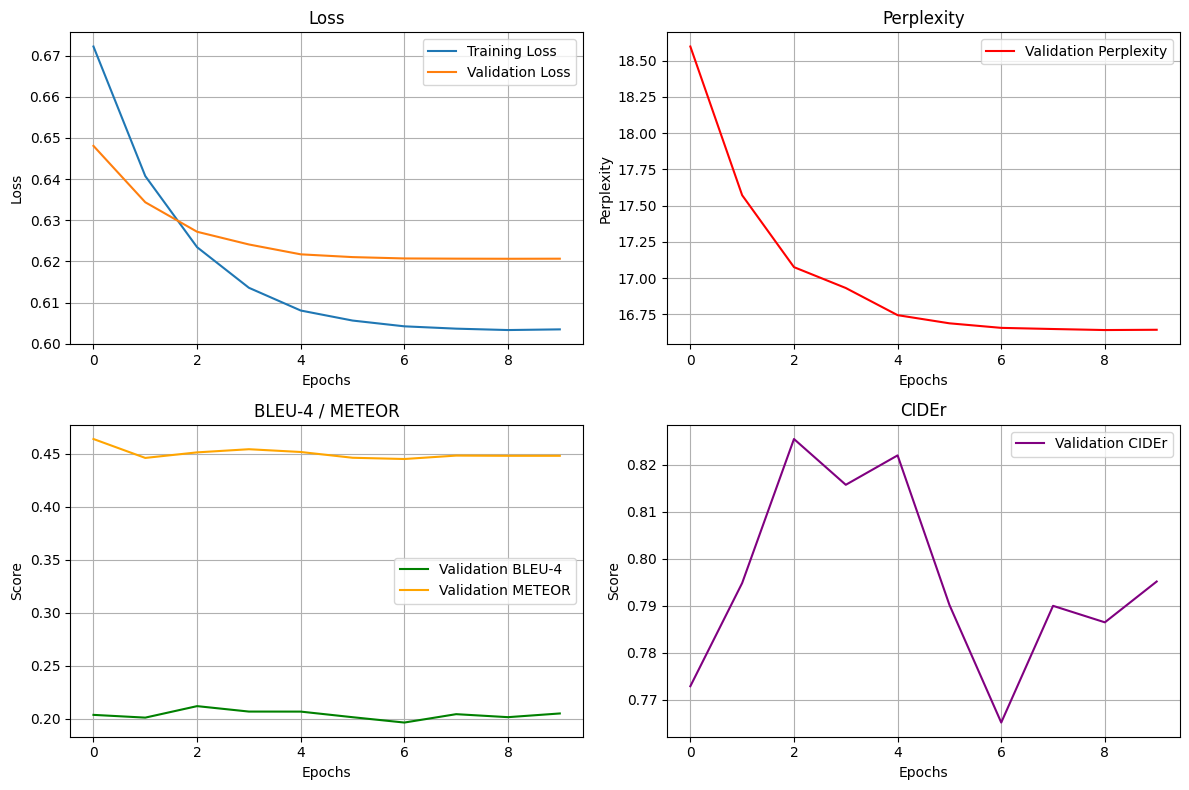

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_loss_plot, label='Training Loss')
plt.plot(val_loss_plot, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(perplexity_plot, label='Validation Perplexity', color='red')
plt.title('Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(bleu4_plot, label='Validation BLEU-4', color='green')
plt.plot(meteor_plot, label='Validation METEOR', color='orange') # <-- AJOUT METEOR PLOT
plt.title('BLEU-4 / METEOR')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(cider_plot, label='Validation CIDEr', color='purple')
plt.title('CIDEr')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
print("\nPlots des métriques sauvegardés dans 'training_metrics.png'")
# plt.show() # Décommente si tu veux voir le plot directement dans le notebook


[v0] training loss plot saved as 'real_training_loss.png'

[v0] Real Performance Summary:

[v0] Real Performance Summary:
Final Validation Loss: 0.620660
Total Epochs Run: 10
Vocabulary Size: 15993
Training Samples: 160081
Validation Samples: 40021
Unique Images Processed: 40000


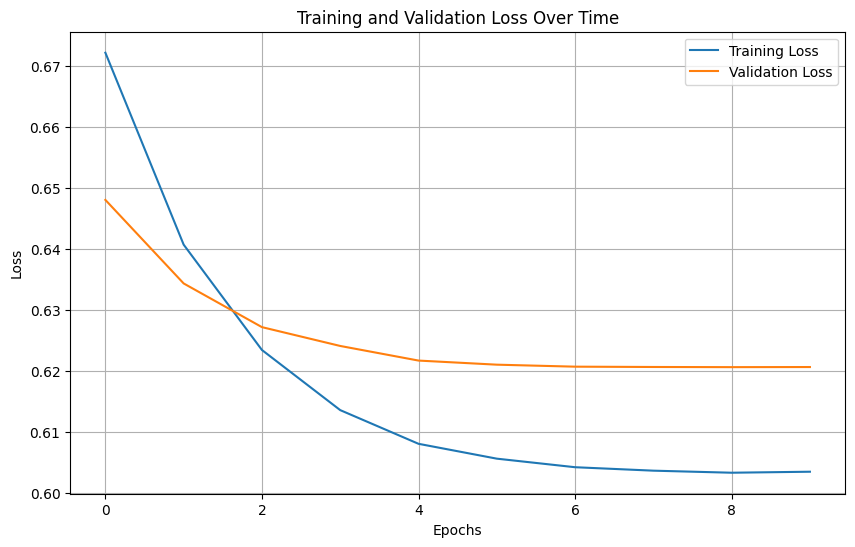

In [55]:

# --- 1. Graphique des VRAIES pertes d'entraînement et de validation ---
# (Ces variables ont été remplies dans la cellule 17)

plt.figure(figsize=(10, 6))
plt.plot(train_loss_plot, label='Training Loss')
plt.plot(val_loss_plot, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.savefig('real_training_loss.png')
print("\n[v0] training loss plot saved as 'real_training_loss.png'")

try:
    actual_vocab_size = len(tokenizer.word_index)
except AttributeError:
    print("ERREUR: 'tokenizer' n'est pas chargé ou est corrompu.")
    print("Exécutez la cellule de restauration (pickle.load) avant celle-ci.")
    actual_vocab_size = -1 # Mettre une valeur d'erreur

print("\n[v0] Real Performance Summary:")
print("=" * 60)

print("\n[v0] Real Performance Summary:")
print("=" * 60)

if 'best_val_loss' in locals():
    print(f"Best Validation Loss: {best_val_loss:.6f}")
else:
    print(f"Final Validation Loss: {val_loss_plot[-1]:.6f}")

print(f"Total Epochs Run: {len(train_loss_plot)}")
print(f"Vocabulary Size: {VOCAB_SIZE}") # Use corrected global var
print(f"Training Samples: {len(img_train)}")
print(f"Validation Samples: {len(img_val)}")
print(f"Unique Images Processed: {len(image_path_to_caption)}") # Corrected reference
print("=" * 60)


[v0] Generating captions for validation samples...

[v0] Test Image 1 (Source Path: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000180048.jpg):
Real captions: <start> A black and white photo of a woman sitting on a bench <end>
Predicted caption: a woman sitting on a bench holding a cell phone


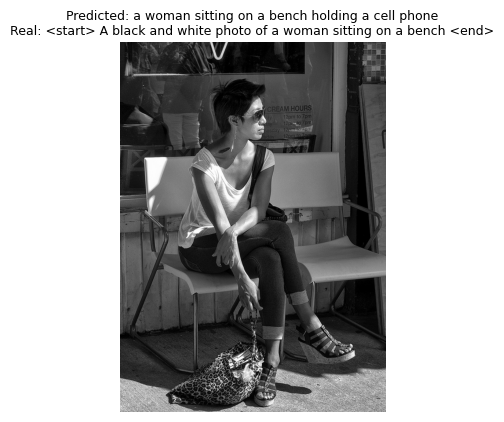


[v0] Test Image 2 (Source Path: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000521549.jpg):
Real captions: <start> There is a tall tower connected to a building. <end>
Predicted caption: a building with a clock on the top of it


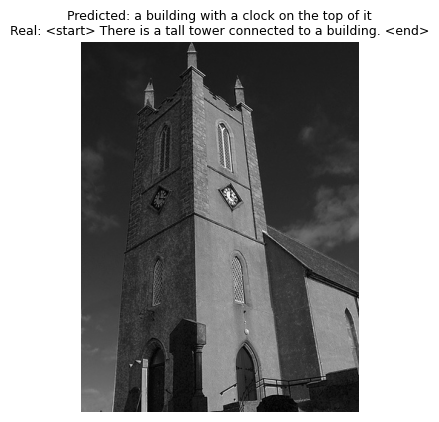


[v0] Test Image 3 (Source Path: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000539647.jpg):
Real captions: <start> A woman holding a cake with her left hand. <end>
Predicted caption: a man holding a piece of cake in front of him


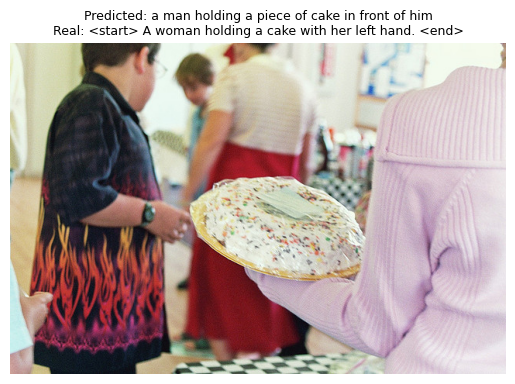


[v0] Test Image 4 (Source Path: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000264110.jpg):
Real captions: <start> A stuffed animal sleeping in a miniature bed under a blanket. <end>
Predicted caption: a black and white cat laying on a bed


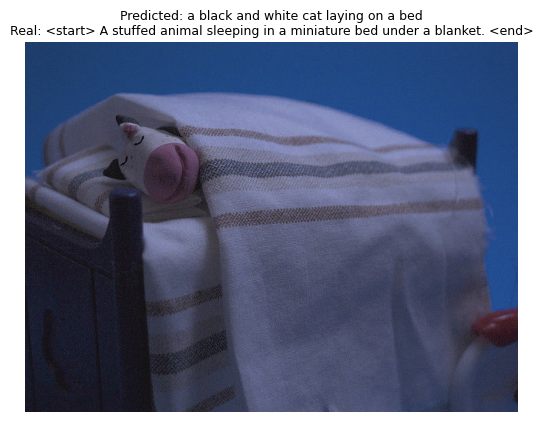


[v0] Test Image 5 (Source Path: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000250698.jpg):
Real captions: <start> BOWL OF DIP WITH SPOON, DIFFERENT VEGETABLES ON A PLATE <end>
Predicted caption: a bowl of food and a bowl of food


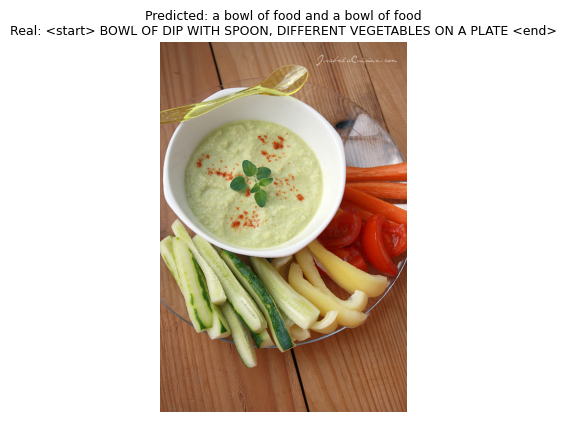


[v0] Test Image 6 (Source Path: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000221328.jpg):
Real captions: <start> a dressed up elephant putting his trunk on a womans head <end>
Predicted caption: a man standing in front of an elephant


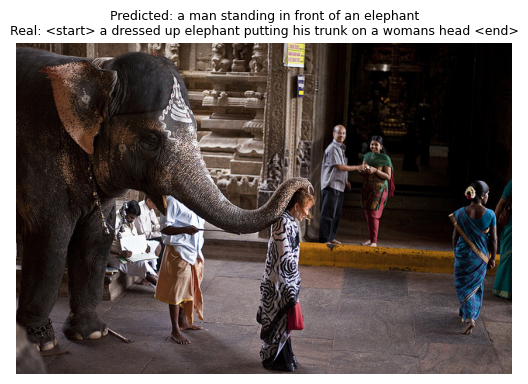


[v0] Test Image 7 (Source Path: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000028307.jpg):
Real captions: <start> A construction worker is holding a stop sign <end>
Predicted caption: a group of people standing next to each other on a street


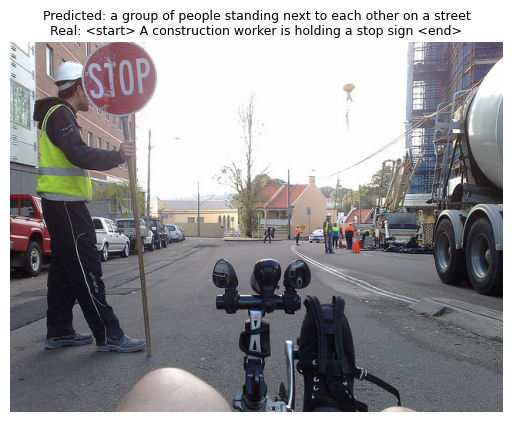


[v0] Test Image 8 (Source Path: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000432742.jpg):
Real captions: <start> Two men in suits exchanging an item and shaking hands. <end>
Predicted caption: a man sitting in front of a table with a laptop


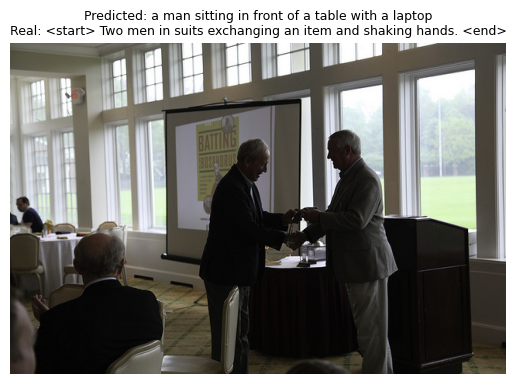


[v0] Test Image 9 (Source Path: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000434991.jpg):
Real captions: <start> a row of trucks parked along a road <end>
Predicted caption: a white truck is parked in a parking lot


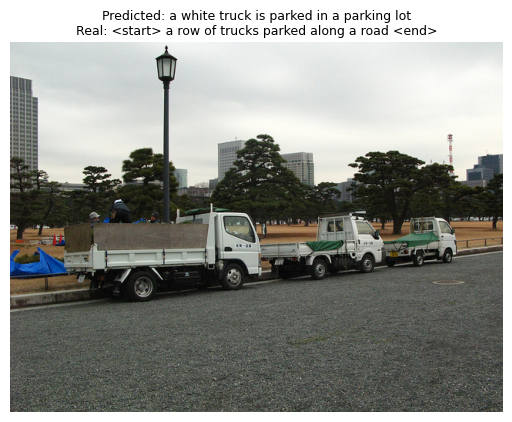


[v0] Test Image 10 (Source Path: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000234956.jpg):
Real captions: <start> A passenger train traveling through the country side. <end>
Predicted caption: a train that is sitting on the tracks


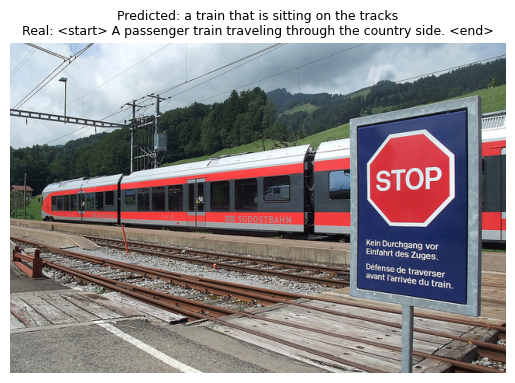

In [56]:
print("\n[v0] Generating captions for validation samples...")
print("=" * 60)

# We need the .npy paths (keys)
image_feature_paths = list(image_path_to_caption.keys())

# Get 10 samples from the validation set (img_val contains .npy paths)
test_npy_paths = img_val[20:30]

for idx, npy_path in enumerate(test_npy_paths):
    # Find the index of this npy_path to get the source JPG path
    try:
        original_index = image_feature_paths.index(npy_path)
        # Utiliser source_image_paths (défini dans la Cellule 4)
        source_jpg_path = source_image_paths[original_index] 
    except (ValueError, IndexError):
        print(f"Error: Could not find original image for {npy_path}")
        continue

    print(f"\n[v0] Test Image {idx+1} (Source Path: {source_jpg_path}):")
    real_captions = image_path_to_caption[npy_path]
    print(f"Real captions: {real_captions[0]}")

    # 'evaluate' (Cellule 22) prend le chemin du JPG
    predicted_tokens, _ = evaluate(source_jpg_path) 
    predicted_caption = ' '.join(predicted_tokens)
    print(f"Predicted caption: {predicted_caption}")

    # Charger l'image pour l'afficher
    img_display = mpimg.imread(source_jpg_path)
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_caption}\nReal: {real_captions[0]}", fontsize=9)
    plt.show()

In [57]:

print("Restauration du meilleur modèle et du tokenizer...")

# 1. Recharger le VRAI tokenizer sauvegardé
with open('tokenizer_best.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
print("  - Tokenizer 'tokenizer_best.pickle' re-chargé.")

# 2. Recharger les poids du MEILLEUR modèle
# (Nécessaire pour que la fonction 'evaluate' utilise le meilleur modèle)
try:
    encoder.load_weights('encoder_best_weights.weights.h5')
    decoder.load_weights('decoder_best_weights.weights.h5')
    print("  - Poids 'encoder_best_weights.h5' et 'decoder_best_weights.h5' re-chargés.")
except Exception as e:
    print(f"Erreur lors du chargement des poids : {e}")
    print("Assurez-vous que les fichiers existent et que les modèles (encoder, decoder) sont bien définis.")

print("Restauration terminée. Vous pouvez lancer l'évaluation BLEU.")

Restauration du meilleur modèle et du tokenizer...
  - Tokenizer 'tokenizer_best.pickle' re-chargé.
  - Poids 'encoder_best_weights.h5' et 'decoder_best_weights.h5' re-chargés.
Restauration terminée. Vous pouvez lancer l'évaluation BLEU.


In [72]:

# Exemple : récupérer toutes les images du dossier
test_image_paths = glob.glob('/kaggle/input/test-images/*.jpg')
print(test_image_paths)

['/kaggle/input/test-images/WhatsApp Image 2025-10-23  11.48.46_4eb94316.jpg', '/kaggle/input/test-images/WhatsApp Image 2025-10-23  11.52.12_97803ae7.jpg']



Image 1: /kaggle/input/test-images/WhatsApp Image 2025-10-23  11.48.46_4eb94316.jpg
Predicted caption: a vase filled with flowers on a table


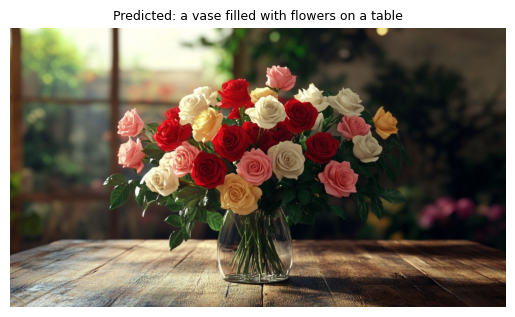


Image 2: /kaggle/input/test-images/WhatsApp Image 2025-10-23  11.52.12_97803ae7.jpg
Predicted caption: a group of people standing next to each other


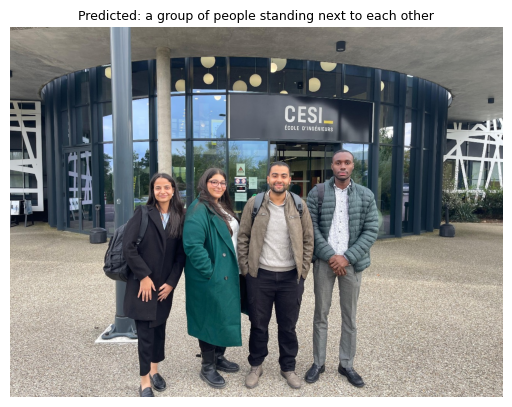

In [73]:

def test_model_on_images(image_paths, method='beam'):
    """
    Teste le modèle sur une liste d'images locales.
    method : 'beam', 'greedy', 'top_k', 'top_p'
    """
    for idx, image_path in enumerate(image_paths):
        print(f"\nImage {idx+1}: {image_path}")

        # Charger et afficher l'image
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')

        # Génération de la légende
        if method == 'beam':
            result_tokens, _ = evaluate(image_path, beam_width=3)
        elif method == 'greedy':
            result_tokens = evaluate_greedy(image_path)
        elif method == 'top_k':
            result_tokens = evaluate_top_k(image_path, k=5)
        elif method == 'top_p':
            result_tokens = evaluate_top_p(image_path, p=0.9)
        else:
            raise ValueError("Méthode inconnue: 'beam', 'greedy', 'top_k', 'top_p'")

        caption = ' '.join(result_tokens)
        print(f"Predicted caption: {caption}")
        plt.title(f"Predicted: {caption}", fontsize=9)
        plt.show()
test_model_on_images(test_image_paths, method='beam')  # ou 'greedy', 'top_k', 'top_p'


In [74]:
import tensorflow as tf
import numpy as np

print("--- DÉBUT DE LA SAUVEGARDE DES MODÈLES COMPLETS ---")

# --- 1. VÉRIFICATION DES PARAMÈTRES (À ADAPTER) ---
# Assurez-vous que ces variables existent et correspondent à votre notebook.
# Je fais des suppositions basées sur votre code précédent.

try:
    # Récupération des variables de votre notebook
    _ = BATCH_SIZE
    _ = UNITS
    _ = EMBEDDING_DIM
    _ = VOCAB_SIZE
    _ = tokenizer
    _ = encoder
    _ = decoder
    
    # Supposition pour la forme des caractéristiques (ex: InceptionV3 8x8)
    INPUT_FEATURE_DIM = 2048 
    FEATURE_SHAPE = 64
    
    print(f"Paramètres trouvés : BATCH_SIZE={BATCH_SIZE}, UNITS={UNITS}, EMBEDDING_DIM={EMBEDDING_DIM}")

except NameError as e:
    print(f"ERREUR : Variable manquante : {e}")
    print("Veuillez vous assurer que 'BATCH_SIZE', 'UNITS', 'EMBEDDING_DIM', 'VOCAB_SIZE', 'tokenizer', 'encoder', et 'decoder' sont définis.")
    # Stoppez l'exécution ou définissez des valeurs par défaut ici si nécessaire
    # Par exemple :
    # BATCH_SIZE = 1 # Mettez votre vraie valeur
    # ... etc.


# --- 2. CONSTRUCTION DES MODÈLES (OBLIGATOIRE POUR .h5) ---
# Nous devons appeler les modèles une fois avec des données fictives
# pour que Keras connaisse leur architecture complète avant de sauvegarder.

print("Construction des modèles avec des données fictives...")

# Forme d'entrée fictive pour CNN_Encoder
# (batch_size, 64, 2048) -> en supposant InceptionV3
dummy_encoder_input = tf.zeros((BATCH_SIZE, FEATURE_SHAPE, INPUT_FEATURE_DIM))

# Forme d'entrée fictive pour RNN_Decoder
# (batch_size, 1) -> le token <start>
try:
    start_token_index = tokenizer.word_index['<start>']
except Exception as e:
    print(f"Alerte : Impossible de trouver le token '<start>', utilisation de '1'. Erreur : {e}")
    start_token_index = 1
    
dummy_decoder_input = tf.expand_dims([start_token_index] * BATCH_SIZE, 1)

# Appeler l'encodeur pour le "construire"
print("Construction de l'encodeur...")
encoder_output_features = encoder(dummy_encoder_input, training=False)

# Appeler le décodeur pour le "construire"
print("Construction du décodeur...")
initial_hidden_state = decoder.reset_state(BATCH_SIZE)
_ = decoder(dummy_decoder_input, 
            encoder_output_features, 
            initial_hidden_state, 
            training=False)

print("Modèles construits avec succès.")


# --- 3. SAUVEGARDE AU FORMAT .H5 ---
ENCODER_SAVE_PATH = 'encoder_complet.h5'
DECODER_SAVE_PATH = 'decoder_complet.h5'

print(f"\nSauvegarde du modèle encodeur complet dans : {ENCODER_SAVE_PATH}")
encoder.save(ENCODER_SAVE_PATH)
print("Encodeur sauvegardé.")

print(f"Sauvegarde du modèle décodeur complet dans : {DECODER_SAVE_PATH}")
decoder.save(DECODER_SAVE_PATH)
print("Décodeur sauvegardé.")

print("\n--- OPÉRATION TERMINÉE ---")
print(f"Fichiers créés : {ENCODER_SAVE_PATH}, {DECODER_SAVE_PATH}")

--- DÉBUT DE LA SAUVEGARDE DES MODÈLES COMPLETS ---
Paramètres trouvés : BATCH_SIZE=64, UNITS=768, EMBEDDING_DIM=256
Construction des modèles avec des données fictives...
Construction de l'encodeur...
Construction du décodeur...
Modèles construits avec succès.

Sauvegarde du modèle encodeur complet dans : encoder_complet.h5
Encodeur sauvegardé.
Sauvegarde du modèle décodeur complet dans : decoder_complet.h5
Décodeur sauvegardé.

--- OPÉRATION TERMINÉE ---
Fichiers créés : encoder_complet.h5, decoder_complet.h5
